In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Jamal
img1 = cv2.imread("/content/drive/MyDrive/computer vision/CV-asg 2/Assignment 2 Dataset/image1.jpg")
img2 = cv2.imread("/content/drive/MyDrive/computer vision/CV-asg 2/Assignment 2 Dataset/image2.jpg")
# Yomna 
#img1 = cv2.imread("/content/drive/MyDrive/8th Term/CV-asg 2/Assignment 2 Dataset/image1.jpg")
#img2 = cv2.imread("/content/drive/MyDrive/8th Term/CV-asg 2/Assignment 2 Dataset/image2.jpg")

In [4]:
print(img1.shape)
print(img2.shape)

(683, 1024, 3)
(683, 1024, 3)


#Getting Correspondences

---



In [5]:
p1 = [[380,290],[310,490],[110,500],[50,175]]
p2 = [[815,315],[765,530],[570,540],[565,240]]

#Compute the Homography Parameters

---



In [6]:
def get_homography(p1, p2):
  n = len(p1)
  b = np.zeros(((2*n),1))
  for i in range(n):
    b[i*2],b[i*2+1] = p2[i]
  a = np.zeros(((2*n),8))
  for i in range(n):
    x, y = p1[i]
    x_dash, y_dash = p2[i]
    a[2*i] = np.array([x, y, 1, 0, 0, 0, -x_dash*x, -x_dash*y])
    a[2*i+1] = np.array([0, 0, 0, x, y, 1, -y_dash*x, -y_dash*y])
  H = np.linalg.lstsq(a, b)[0]
  H = np.append(H,1)
  H = H.reshape((3,3))
  return H

#Warping Between Image Planes

---



In [7]:
def get_warped_image_shape(img, H):
  h = img.shape[0]
  w = img.shape[1]
  boundries = np.array([[0, 0],
                        [h-1, 0],
                        [0, w-1],
                        [h-1, w-1]])
  x_dash = np.zeros(4, dtype=int)
  y_dash = np.zeros(4, dtype=int)

  for i in range(0,4):
    y = boundries[i][0]
    x = boundries[i][1]
    point = np.array([[x],[y],[1]])
    point_dash = np.dot(H, point)
    point_dash = point_dash / point_dash[2][0]
    y_dash[i] = int(point_dash[0][0])
    x_dash[i] = int(point_dash[1][0])

  min_x_dash = np.min(x_dash)
  min_y_dash = np.min(y_dash)
  max_x_dash = np.max(x_dash)
  max_y_dash = np.max(y_dash)
  
  new_h = max_x_dash - min_x_dash + 1
  new_w = max_y_dash - min_y_dash + 1
  h_shift =-min_x_dash
  w_shift =-min_y_dash

  return (new_h, new_w, h_shift, w_shift)

In [13]:
def make_warping(img, H):
  h = img.shape[0]
  w = img.shape[1]
  warped_h, warped_w, h_shift, w_shift = get_warped_image_shape(img, H)
  warped_img = np.zeros((warped_h, warped_w, 3), dtype=np.uint8)
  for i in range(0, img.shape[0]):
    for j in range(0, img.shape[1]):
      p = np.array([[j], [i], [1]])
      p_dash = np.dot(H, p)
      p_dash = p_dash / p_dash[2][0]
      py = int(p_dash[0][0])
      px = int(p_dash[1][0])
      warped_img[px + h_shift][py + w_shift] = img[i][j]
  
  return warped_img, h_shift, w_shift

#Getting Output

---



In [9]:
h, status = cv2.findHomography(np.array(p2), np.array(p1))
print(h)

[[ 2.96282834e+00  6.03115922e-01 -1.72020192e+03]
 [ 3.29246304e-01  3.30381589e+00 -6.34036262e+02]
 [ 7.25970602e-04  2.33627070e-03  1.00000000e+00]]


In [10]:
test = np.dot(h,np.array([[815],[315],[1]]))
test = test / test[2][0]
print(test)

[[380.]
 [290.]
 [  1.]]


In [14]:
H = get_homography(p1=p2, p2=p1)
out_img = make_warping(img=img2, H=H)
print(H)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


[[ 2.96282834e+00  6.03115922e-01 -1.72020192e+03]
 [ 3.29246304e-01  3.30381589e+00 -6.34036262e+02]
 [ 7.25970601e-04  2.33627070e-03  1.00000000e+00]]


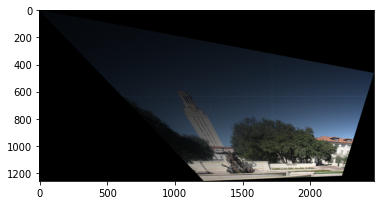

In [15]:
plt.imshow(cv2.cvtColor(out_img[0],cv2.COLOR_BGR2RGB))

In [16]:
def create_mosaic(wraped_image, second_view, h_shift, w_shift):
  wraped_image_h = wraped_image.shape[0]
  wraped_image_w = wraped_image.shape[1]
  second_view_h = second_view.shape[0]
  second_view_w = second_view.shape[1]
  mosaic_h=0
  mosaic_w=0

  if wraped_image_h > second_view_h + h_shift :
    mosaic_h = wraped_image_h
  else:
    mosaic_h = second_view_h + h_shift

  if mosaic_w > second_view_w + w_shift:
    mosaic_w = mosaic_w
  else:
    mosaic_w = second_view_w + w_shift

  mosaic = np.zeros((mosaic_h, mosaic_w, 3), dtype=np.uint8)
  
  for i in range(0,second_view_h):
    for j in range(0, second_view_w):
      mosaic[i + h_shift][j + w_shift] = second_view[i][j]
  
  for i in range(0, wraped_image_h):
    for j in range(0, wraped_image_w):
      if not(int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][1]) == 0 and int(wraped_image[i][j][2]) == 0):
        mosaic[i][j] = wraped_image[i][j]
        
  return mosaic

In [17]:
mosaic=create_mosaic(out_img[0],img1,out_img[1],out_img[2])

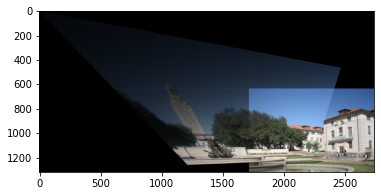

In [18]:
plt.imshow(cv2.cvtColor(mosaic,cv2.COLOR_BGR2RGB))